In [1]:
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.metrics import make_scorer, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Partisan news

We will learn some of the basic techniques for handling machine learning problems in Python, using the popular machine learning package **scikit-learn**. Our example task is to train a model that can identify news stories that are written from a politically partisan perspective, and distinguish them from mainstream stories that are written from a more or less neutral perspective. This is related to the problem of detecting fake news but is slightly different; we want to be able to identify whether a news story is 'pushing' political opinions, even if its content is factually correct.

This is a *supervized classification* problem. *Classification* because the task involves classifying inputs into two or more categories. *Supervized* because there is a correct answer for each input, and the model that we train will need to be told those correct answers in order to learn what features of the input can be used to predict them.

As the learning data, we will use a slightly modified version of the [BuzzFeed-Webis fake news corpus 2016](https://doi.org/10.5281/zenodo.1239675). The data are contained in two text files in which each paragraph is a separate news story. One file contains mainstream news and another contains partisan news.

## Data handling

Our first step is to load the data in a format suitable for supervized classification. We need the news stories in a list or array, so that we can slice them easily into subsets, and we need a corresponding list of the correct labels for the stories. We will call the stories the *items* and their true categories the *labels*.

In [2]:
filenames = ['mainstream', 'partisan']
items = []
labels = []

# regular expression matching a story:
# one or more characters followed by one or more newlines
storyRE = '.+(?=\n+)'

for filename in filenames:
    stories = re.findall(storyRE, open(filename + '.txt', encoding='utf-8').read())
    items = items + stories
    labels = labels + [filename] * len(stories)

n_stories = len(items)
n_mainstream = labels.count('mainstream')
n_partisan = labels.count('partisan')
print('{} stories: {} mainstream and {} partisan'.format(n_stories, n_mainstream, n_partisan))

1590 stories: 822 mainstream and 768 partisan


Let's print the final story to make sure the content looks right.

In [3]:
print(labels[-1])
print(items[-1])

partisan
Good luck getting through this video without wanting to punch your screen. This guy is a wreck. He was pulled over for a traffic violation, and from the get go was the most obnoxious, immature, race-baiting buttface you have probably heard in a very long time. I have got to hand it to the Police Officer, this is the kind of garbage they have to deal with now ALL THE TIME… even soccer moms are being absolute terrors to Police Officers when they get pulled over now. What used to be a every now and then difficulty has become a daily thing for these Police Officers to have to deal with. All the sudden with Obama’s America everyone feels entitled, and have learned a few big words that they like to use when Police pull them over…to try and what? Make the police hesitate because of all the BLM garbage going on? Make them feel like they can break the law and not have to answer to Police if they are a minority? Can you imagine how patient the Police have to be now? NO ONE and I repeat 

## Training and test data

We are going to use these news stories to 'train' a model. Ours is a supervized learning problem, so we have the correct labels for the news stories and will allow the model to 'see' these correct labels. It will then use this information to develop a classification scheme that most accurately classifies the stories. Our hope in so doing is that the resulting classification scheme will generalize to new similar stories for which the model has not seen the true correct label.

We would like to be able to actually assess how well the trained model generalizes. For this, we need new data of the same kind. We don't yet have any new data, but we can of course just set aside some of the data we already have, and use it as 'new' data to test the model's performance once we have finished training it with the remaining data.

There is a trade-off when deciding how much data to set aside for testing. If we set aside a larger test data set, we will get a more precise estimate of the model's generalization performance when we test it, because we will be doing so with more data. But we will also tend to get a more pessimistic estimate of the model's performance, because we will have given it less information to train on, and so it may not have reached its full potential. A common compromis is to set aside one quarter of the data for testing, and use the remaining three quarters for training.

scikit-learn's `train_test_split` can be used to shuffle and split lists of data, and it implements the 3:1 split as its default training to test ratio. We can also ask to 'stratify' the split, to ensure that the training and test data contain equal proportions of different types of items. Here we stratify by the story labels, ensuring that the two data splits contain equal proportions of mainstream and partisan stories. Because the shuffling involves randomness but we would like our work to be exactly reproducible if someone else runs our program, we set the initial state of the random number generator to some arbitrary value, so the shuffling will be the same every time we run it.

In [4]:
train_items, test_items, train_labels, test_labels = train_test_split(items, labels, stratify=labels, random_state=0)

It is important that we leave our test data alone until we have really finished developing our model. If we repeatedly check the model's performance on the test data, then return to an earlier step and modify the model in order to improve its performance, then we are allowing the model to adapt to the test data, indirectly via our modifications. We will then tend to get an overly optimistic impression of how well the model generalizes, because we have specially tuned it to perform well on the test data. So in the steps that follow, we will always use only the training data, turning to the test data only at the very end of our workflow.

## Vectorization

In order for our learning model to make use of the data, we need to turn them into *features*: clearly-defined characteristics for which each item receives a numeric value. This process is known as *vectorization*, because each item is converted into a vector of numbers that represents its values for the features.

The choice of features is up to us. We should choose features that we think will be informative or that we want the model to learn from. In principle, our choice is unconstrained. We could use counts of single characters in the text, lengths of words, or even the positions of specific characters. But an obvious and common choice for text learning tasks is counts of particular words. We know that the presence of certain words (or combinations of words) in a text is likely to be related to its tone and content. If we were to instead choose counts of character combinations, we would be requiring our model to first learn to combine characters into words, and in a way that takes into account the special meaning of the space character and the apostrophe and so on. This is unnecessary and would only make our model's task harder.

The scikit-learn package provides vectorizer classes for various vectorization tasks. We initialize a vectorizer object to use as the first step in our learning pipeline. This object will take the list of raw text data as its input, and will output the vectors of feature values, organized in a matrix. The `CountVectorizer` class produces vectors of word or character counts. It has several adjustable parameters that can help make the features more informative:

* whether to include combinations of 2 or more words (so-called *ngrams*)
* whether to exclude certain common words such as 'a' and 'the' whose use is unlikely to vary across texts (so-called *stop words*)
* whether to convert all words to lowercase
* whether to exclude terms that occur too rarely in the whole corpus of texts
* whether to exclude terms that occur too frequently in the whole corpus of texts
* ...

We can then 'fit' the vectorizer to our texts to apply the processing steps we requested. After fitting, we can see what features the vectorizer has extracted.

In [5]:
vectorizer = CountVectorizer(ngram_range=(1, 2), # get single words and pairs of words
                             stop_words='english',
                             lowercase=True,
                             min_df=3, # use only terms that occur in at least 3 texts
                             max_df=0.9) # don't use terms that occur in more than 90% of texts

vectorizer.fit(train_items)
features = vectorizer.get_feature_names()

print(features[:20], features[-20:])

['00', '000', '000 30', '000 additional', '000 emails', '000 mails', '000 pages', '000 payment', '000 people', '000 prevented', '000 refugees', '000 syrian', '000 times', '000 trump', '000 voters', '000 year', '01', '01 cet', '01 pm', '02'] ['zach galifianakis', 'zach hudson', 'zapfel', 'zapfel kristen', 'zekejmiller', 'zero', 'zika', 'zika funding', 'zika virus', 'zimmer', 'zinger', 'zinger night', 'zingers', 'zone', 'zones', 'zoning', 'zu', 'zu werden', 'zuckerberg', 'zuckerberg right']


We can see that scikit-learn's vectorizer probably hasn't done such a great job with our data. The alphabetically first 10 features all begin with the numeric character '0' and are unlikely to be useful. It has also counted singular and plural forms of words as two different features, whereas they are probably better thought of as repeated occurrences of the same word.

For messy, real-world texts it is often necessary to call on natural language processing packages such as **nltk** or **spacy** to preprocess the text before passing it on to scikit-learn. These packages can be used to collapse singular and plural forms and different conjugations of the same verb, or to focus on the most informative parts of speech such as nouns, adjectives, and verbs. To keep our example simple and to focus on the scikit-learn workflow, we will omit doing any additional natural language processing here. But a more elaborate script `partisan_news.py` is provided that illustrates the integration of spacy and other useful preprocessing steps.

One slight improvement that is possible without additional packages is the use of a custom analyzer function. The `CountVectorizer` allows us to pass in our own function for turning the text into features. This function should take a string as its input and return a list of features. Let's create such a function and pass it to a new vectorizer object. Our function applies the following steps:

* replace some characters with spaces
* split the text into words
* strip words of surrounding non-letter characters
* remove apostrophes
* discard words containing non-letter characters
* convert words to lowercase
* return single valid words and pairs of adjacent valid words (so-called *bigrams*)

In [6]:
def preprocess(text):
    for char in '/-':
        text = text.replace(char, ' ')
    features = []
    previous_word = False
    for word in text.split():
        match = re.search('[a-zA-Z].*[a-zA-Z]', word)
        if match:
            word = match.group(0)
        else:
            word = ''
        for char in "'’":
            word = word.replace(char, '')
        if word and word.isalpha():
            word = word.lower()
            features.append(word)
            if previous_word:
                features.append(' '.join([previous_word, word]))
            previous_word = word
        else:
            previous_word = False
    return features

vectorizer = CountVectorizer(analyzer=preprocess,
                             min_df=3,
                             max_df=0.9)

vectorizer.fit(train_items)
features = np.array(vectorizer.get_feature_names())

print(features[:20])
print(features[-20:])

['aaron' 'abandon' 'abandon his' 'abandon the' 'abandoned' 'abandoning'
 'abbi' 'abbi easter' 'abbott' 'abbott said' 'abby' 'abc' 'abc news'
 'abcs' 'abdel' 'abdel fattah' 'abe' 'abedin' 'abedin and' 'abide']
['zach galifianakis' 'zach hudson' 'zapfel' 'zapfel kristen' 'zekejmiller'
 'zero' 'zika' 'zika funding' 'zika virus' 'zimmer' 'zinger' 'zinger of'
 'zingers' 'zone' 'zones' 'zoning' 'zu' 'zu werden' 'zuckerberg'
 'zuckerberg right']


This somewhat primitive preprocessing function doesn't handle complex problems like conjugation, but it does a better job of discarding numbers and some other non-word sequences.

Let's now take a look at the result of the vectorization process. After fitting, the vectorizer can output the vector representation of the features in the data. The result is a matrix of numbers, in which the rows represent the items (in our case the news stories), the columns represent the features (in our case words and bigrams), and each cell is the value for that item for that feature (in our case an integer count of how often that word or bigram occurs in that story).

In [7]:
train_vect = vectorizer.transform(train_items)

print(train_vect.shape)

(1192, 47010)


This matrix is pretty big, because there are so many different words and bigrams in the whole set of stories. However, most of these terms occur in only a few of the stories. This is a [well-known phenomenon in linguistics](https://en.wikipedia.org/wiki/Zipf%27s_law); everyday language use relies mainly on a small subset of words that are used extremely frequently, but most of the words that exist are used only rarely. How many times a day do you talk about antidisestablishmentarianism?

The result is that our feature matrix is a [*sparse matrix*](https://en.wikipedia.org/wiki/Sparse_matrix), a matrix in which most entries are zero. Rather than store all those zeros explicitly, scikit-learn saves memory by instead representing such feature matrices as a collection of the indices and values of the non-zero entries only. We can see this if we print the matrix out. For example, the first non-zero entry of the matrix tells us that the 2nd feature (the name 'abadi') appears once in the first story.

In [8]:
print(type(train_vect))
print(train_vect)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 37)	1
  (0, 108)	1
  (0, 324)	1
  (0, 406)	1
  (0, 432)	1
  (0, 639)	8
  (0, 683)	1
  (0, 684)	3
  (0, 730)	1
  (0, 749)	1
  (0, 786)	2
  (0, 839)	1
  (0, 1083)	1
  (0, 1122)	1
  (0, 1124)	1
  (0, 1503)	2
  (0, 1665)	1
  (0, 1684)	1
  (0, 1784)	1
  (0, 2118)	1
  (0, 2325)	1
  (0, 2610)	1
  (0, 2654)	1
  (0, 2845)	2
  (0, 2854)	1
  :	:
  (1191, 44896)	1
  (1191, 45003)	1
  (1191, 45049)	1
  (1191, 45082)	1
  (1191, 45149)	1
  (1191, 45152)	1
  (1191, 45208)	1
  (1191, 45405)	3
  (1191, 45465)	1
  (1191, 45541)	1
  (1191, 45661)	3
  (1191, 45671)	3
  (1191, 45796)	1
  (1191, 45797)	1
  (1191, 45886)	3
  (1191, 46047)	1
  (1191, 46070)	1
  (1191, 46128)	1
  (1191, 46129)	1
  (1191, 46378)	1
  (1191, 46380)	1
  (1191, 46399)	2
  (1191, 46468)	1
  (1191, 46473)	1
  (1191, 47004)	1


## Transformation

An optional next step is to transform the feature values in some way. We don't have to do this, but sometimes there can be transformations that may improve the usefulness of the features for a given problem or model type.

### TF-IDF

Though perhaps not absolutely necessary here, for demonstration purposes we will apply one popular transform for word counts, a 'TF-IDF' transform. **TF-IDF** stands for **T**erm **F**requency - **I**nverse **D**ocument **F**requency, and it consists in increasing the count values for each term in inverse proportion to the number of documents in which that term occurs. So terms that are rare across the whole set of stories will be given a larger TF-IDF value in the few texts in which they do occur, reflecting the fact that those terms are special to just those texts. Likewise, terms that have a high count in one text but also occur in other texts will have a reduced TF-IDF value, reflecting the fact that their occurrence is not particularly special for any one type of text.

There are a few variations on how exactly the IDF component of the transform is calculated. By default, scikit-learn applies the following formula:

$$
tfidf(t,d) = tf(t,d) \times (log \frac{1+n}{1+df(t)} + 1)
$$

Where:

* $tf(t,d)$ is the term frequency for term $t$ in document $d$, i.e. the number of times that term occurs in that document
* $df(t)$ is the number of documents in the whole corpus that contain term $t$
* $n$ is the total number of documents

We can see the consequences of this transform for different kinds of terms by implementing it in a short function and then applying it to some hypothetical values of $tf(t,d)$ and $df(t)$. We can see that terms that occur in every document retain their raw counts, but terms that are rarer across the whole set of texts have their count 'boosted'.

In [9]:
def tfidf(tf, df, n):
    return tf * (np.log((1 + n) / (1 + df)) + 1)

n = 100

for tf in [1, 10]:
    for df in [1, 100]:
        print('Term Frequency {}\tDocument Frequency {}\t-> TF-IDF {}'.format(tf, df, tfidf(tf, df, n)))

Term Frequency 1	Document Frequency 1	-> TF-IDF 4.921973336281314
Term Frequency 1	Document Frequency 100	-> TF-IDF 1.0
Term Frequency 10	Document Frequency 1	-> TF-IDF 49.219733362813145
Term Frequency 10	Document Frequency 100	-> TF-IDF 10.0


To understand why this transform might be a good idea, consider the simpler task of ranking web pages for their relevance to a search query (indeed, this is the application that the TF-IDF transform was originally developed for). If we search with the query 'arguments against antidisestablishmentarianism', all three of the words in our query are relevant indicators of relevance the topic that we are searching for, but they are probably not equally relevant. The term 'antidisestablishmentarianism' is somewhat more relevant than the other two; it is such a rare term that its presence is a fairly sure indicator that the web page is at least somewhat relevant to our query. This is not true of 'arguments' or 'against'; these are common words on many web pages, so their presence doesn't necessarily pick out just those pages we are interested in. We should therefore weight the importance of 'arguments' and 'against' somewhat less.

The same applies to our classification task. Words and bigrams that occur in many of the news stories are probably less likely to be useful indicators of a specific type of story.

In scikit-learn, we can apply transforms by initializing a transform object and then fitting it to the vectorized data. We can see a pattern emerging in the way scikit-learn is structured; each step in the process is handled by an object that we initialize with certain parameters. This object then takes as its input the output of the previous step in the process.

The `fit_transform` method is a convenience that applies both fitting and transformation, two steps that can also be performed separately (as we did for the vectorizer above).

In [10]:
transformer = TfidfTransformer()
train_tfidf = transformer.fit_transform(train_vect)

We can (and should) explore which terms have received low and high IDF values. This is a useful sanity check to make sure that our preprocessing is doing something reasonable with the input text. The numpy `argsort` function can be used to sort the array of feature names by their IDF values, which are stored as an attribute of our fitted transformer object.

We can see here that the terms with lowest IDF are everyday words likely to occur in almost all of the news stories, and the terms with the highest IDF are mostly bigrams.

In [11]:
idf = transformer.idf_
features_by_idf = features[np.argsort(idf)]

print(features_by_idf[:20])
print(features_by_idf[-20:])

['with' 'it' 'be' 'this' 'was' 'not' 'as' 'of the' 'have' 'by' 'at' 'he'
 'has' 'but' 'an' 'in the' 'who' 'are' 'said' 'from']
['said fox' 'ferrandino cole' 'said later' 'few hundred' 'said pence'
 'said our' 'ferrulo' 'said once' 'ferrulo damien' 'said officers'
 'said lets' 'fervently' 'said now' 'fesler david' 'feuding' 'said mr'
 'few bad' 'few feet' 'fesler' 'zuckerberg right']


## Feature selection

We saw above that our corpus of news stories contains a huge number of features. We might be able to make our task a little easier by first whittling these down to a subset of features most likely to be relevant before applying any learning model. We can rank the features by some relevant criterion, and then retain a proportion of the highest ranking features.

scikit-learn provides a `feature_selection` module with various functions for ranking and selecting features. Here we will use the chi-squared statistic to rank the features. This is a statistic that measures how 'unevenly often' a feature occurs in the different types of news story. So a feature that occurs relatively more often in the partisan stories than in the mainstream stories, or vice versa, will have a high chi-squared value, and a feature that occurs equally often in both types of text will have a low chi-squared value. We will select the top 10 per cent of features by chi-squared.

This is the first step in our pipeline that requires us to input the true labels of the items as well as the items themselves.

The `get_support` method of the feature selection object provides a boolean filter that can be used as an index to the features, retrieving only those that were selected.

In [12]:
feature_selecter = SelectPercentile(chi2, percentile=10)
train_selected = feature_selecter.fit_transform(train_tfidf, train_labels)
features_used = features[feature_selecter.get_support()]

print(train_selected.shape)

(1192, 4701)


As before, we can use attributes of the feature selecter object to explore and check the results of our processing so far.

In [13]:
chisq = feature_selecter.scores_
features_by_chisq = features[np.argsort(chisq)]

print(features_by_chisq[-20:])

['black lives' 'cet by' 'sen' 'monday' 'september' 'cet' 'trump said'
 'continued' 'lives matter' 'percent' 'senate' 'your' 'voters' 'trump'
 'story continued' 'continued below' 'campaign' 'debate' 'clinton' 'said']


Here we see an aspect of this data set that might present a small difficulty for training our model. Among the terms that are most disproportionately frequent in one or the other type of story are two proper names ('Trump' and 'Clinton'), a few other terms that clearly refer to specific political events (such as 'September'), and others that clearly have to do with the format and layout of the stories in particular news sources ('continued below' and 'story continued').

Our model will probably make use of these terms in its classifications. This isn't necessarily a bad thing. If certain specific topics really are mentioned more or less often in partisan news stories, or if stories of the same type do tend to be formatted in the same way even across different news sources, then these features will be helpful in classifying new stories. But hot news topics will change over time, and we might want to apply our model to news sources not contained in this data set. In this case, we probably want to prevent our model from learning from things like proper names, references to specific current events, and so on. This is something that we can most easily achieve in the preprocessing steps that we applied above. We might want to return to the preprocessing later and try to exclude proper names or certain specific phrases that we are confident are not indicators of partisanship. Again, this will often be easier using additional NLP packages.

In this example, we will leave the terms as they are and see what happens, bearing in mind that our trained model may end up reflecting some idiosyncratic features of this particular data set alongside some features that are more 'timeless' indicators of partisanship.

## Classification

We are now ready to apply a learning model to the vectorized, transformed, feature selected items and their labels. scikit-learn provides a wide range of 'ready-made' machine learning model classes. Here we will try out just two of the most common model types for text classification problems.

### Naive Bayes

One way of classifying our news stories is to assign each of them a probability of being partisan, using the conditional probability of partisanship given the text's feature values. This can be computed using Bayes' rule:

$$
P(partisan|x) = \frac{P(partisan) \times P(x|partisan)}{P(x)} 
$$

Where $x$ is a vector of $n$ feature values $x_1,\dots,x_n$.

We can estimate the required probabilities using the observed feature values in the two categories of texts in our training data.

However, this presents a problem. It is usually not feasible to estimate the probability of every specific combination of feature values. Think about asking the question "What is the probability that a partisan text contains the terms 'Richard Gere', 'hamster', 'lubricant', and 'emergency room' (and of course the term 'allegedly')?" We just don't have enough information to reliably estimate the probability of elaborate combinations of terms.

In order to overcome this problem, we can make a big simplifying assumption: That within any one category of text, the probability of a given feature value is independent of the values of other features in the same text (i.e. that one term occurring a given number of times does not change the probability of other terms occurring in the same text). If we make this assumption, then we can use the multiplication rule to calculate the probabilities of combinations of terms simply as the product of the probabilities of the individual terms in the combination:

$$
P(partisan|x) = \frac{P(partisan) \times \prod_{i=1}^{n} P(x_i|partisan)}{P(x)} 
$$

And since the $P(x)$ term in the denominator of the formula is always the same, we can simplify it away and say that the probability of a text being partisan is proportional to the term in the numerator:

$$
P(partisan|x) \propto P(partisan) \times \prod_{i=1}^{n} P(x_i|partisan) 
$$

Classification using probabilities calculated by Bayes' rule assuming the independence of feature values is known as 'Naive Bayes' classification. 'Naive' because the assumption that feature values are independent of one another is almost certainly false for most collections of texts. A news story that mentions 'hamster' and 'Richard Gere' will probably be more likely to mention 'allegedly' than otherwise (at least if the journalist wants to keep their job).

But it turns out for most text classification problems that violations of this assumption don't really matter much, and Naive Bayes is often a good classification model. In addition, it is computationally extremely fast to train compared to many other models, because it requires plugging the feature values into the formula just once, whereas many other models need to learn from the training data set by processing it repeatedly.

As before, we can implement a Naive Bayes classifier by initializing a scikit-learn object with some parameters, then inputting the data output by the previous step in our pipeline. We will use one of the parameters to instruct the model not to estimate the prior probabilities of the two types of text $P(partisan)$ and $P(\lnot partisan)$ but instead to just treat them as equally probable. It doesn't really make sense here to try to learn how often each type of text occurs, since we in any case have a data set that has been constructed so that the two types of text occur approximately equally often.

In [14]:
classifier = MultinomialNB(fit_prior=False)
classifier.fit(train_selected, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

We would like now to evaluate how good our Naive Bayes classifier is and to interpret what exactly it has learned from the data. We will do this below, but first we will take a short detour to look at a different type of learning model.

### Decision trees

Another, conceptually quite different, way of classifying texts is via a sequence of 'decision rules'. We can look at the collection of texts and ask which feature value criterion separates the texts into two maximally homogeneous groups, then look at each of these two groups and ask the same question again of each of them. For example, we might find that texts that often mention 'hamster' tend to be partisan, but then find that among these texts, those that also mention 'allegedly' tend nonetheless to be mainstream.

This is quite different from Naive Bayes classification. Sequential decision rules consider the relevance of each feature *after* having first made use of other more informative features. As such, they do not assume that features are independent of one another. This is perhaps a more realistic approach for text data.

The downside of decision trees is that if they are allowed to continue applying decision rules indefinitely, some of the rules that they learn will tend to serve only to make very trivial distinctions among a small number of texts on the basis of very arbitrary features that happen to occur in the training data but are unlikely to recur in new data. For example, after having applied several decision rules to identify a group of mostly mainstream texts, the decision tree might find that the two or three partisan texts that remain in this group happen to mention 'antidisestablishmentarianism', and so learn a rule that classifies some texts containing this term as partisan.

We can control this aspect of the decision tree's behavior by setting a limit on the 'depth' of the decision tree, i.e. how many times it is allowed to split the set of texts. This too is quite unlike Naive Bayes classification. Although the Naive Bayes classifier has a few adjustable parameters (which we do not explore here), these tend not to make a big difference to its generalization performance. The depth of a decision tree on the other hand can make a big difference to how well it generalizes. Too shallow, and it will not learn enough from the training data. Too deep, and it will learn trivial rules that serve to distinguish only a handful of texts in the training data but will probably not generalize.

It is common to start exploring decision trees with a fairly shallow depth such as 3 or 4 splits, then check the result, and increase the depth if the resulting model seems reasonable. scikit-learn provides a neat plotting function `plot_tree` for visualizing a fitted decision tree. Let's use it here to explore a decision tree for our training data.

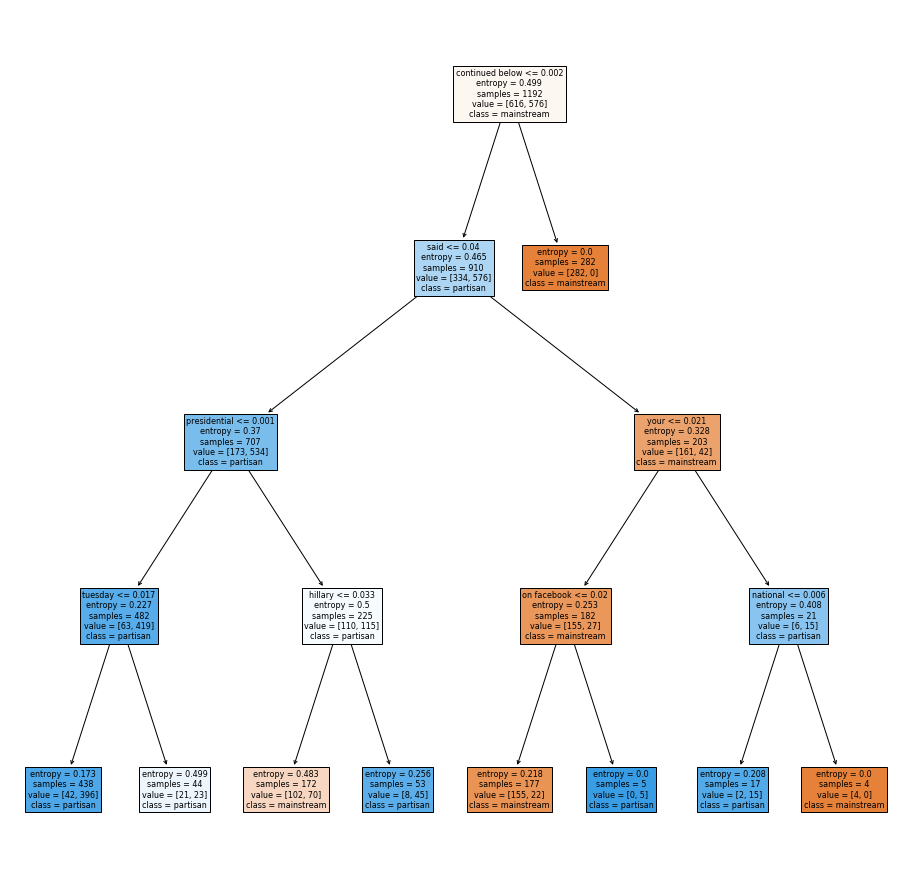

In [15]:
classifier_tree = DecisionTreeClassifier(max_depth=4, random_state=0)
classifier_tree.fit(train_selected, train_labels)

plt.figure(figsize=(16, 16))
plot_tree(classifier_tree,
          feature_names=features_used,
          class_names=filenames,
          filled=True)
plt.show()

The first line of the label for each node of the plot tells us the decision rule that was applied. For text data these rules tend to end up being more or less binary; the cutoff for the feature value is close to zero, so that the texts are split according to whether or not they contain a particular term at all.

Here we can see, rather disappointingly, that the best first split of the texts is achieved by asking whether they contain the term 'continued below' (`continued below <= 0.002`). The final line of the node label tells us what type of text tends to fulfil this criterion. In this case, it is the mainstream texts that fulfil the criterion, i.e. tend not to contain this term.

The end nodes of the plot tell us about the status of the model's decisions after applying the maximum number of splits that we allowed. For example, the leftmost node in the bottom row tells us that 438 news stories were classified as partisan, 396 correctly so, and 42 erroneously. By tracing the decision tree upwards from this end node we can see that these stories were classified as partisan because they did not contain the term 'continued below', nor 'said', nor 'presidential', nor 'tuesday'.

Visualizing and interpreting the tree of decisions is an important step in developing a decision tree model. In this case we can see that there is probably more work to be done before our model is clearly interpretable and likely to generalize to new data. It makes use of certain features that might be quite specific to the news stories covered in our corpus ('Tuesday', 'Hillary') and that might not be generalizable indicators of partisanship.

## Pipelines

For the remainder of the example, we will set decision trees aside and return to the Naive Bayes classifier that we trained earlier. What we would now like to do is to assess the classifier's performance and find out what it has learned from the data. Usually after checking and interpreting the model we will return to earlier steps in the pipeline and alter some of their parameters so as to improve the model's performance. Then we might check again and make further improvements. This iterative process involves repeatedly fitting all of the steps in our pipeline to the data.

To make this a bit easier, scikit-learn provides a 'pipeline' class that can be used to group data processing and learning steps in a single object. We input the objects as tuples of `(name, object)`. The resulting pipeline has a single `fit` method that feeds the data into the first step, then feeds the output of each step into the next. We can also ask the pipeline to be 'verbose', i.e. to print out some messages about its progress during fitting. This can be useful for more complex models that may take some time to process.

In [16]:
model = Pipeline([('vectorize', vectorizer),
                  ('transform', transformer),
                  ('select', feature_selecter),
                  ('classify', classifier)],
                 verbose=True)

model.fit(train_items, train_labels)

[Pipeline] ......... (step 1 of 4) Processing vectorize, total=   2.4s
[Pipeline] ......... (step 2 of 4) Processing transform, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing select, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing classify, total=   0.0s


Pipeline(memory=None,
         steps=[('vectorize',
                 CountVectorizer(analyzer=<function preprocess at 0x7f6fc234dc80>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=None, min_df=3,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('transform',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('select',
                 SelectPercentile(percentile=10,
                                  score_func=<function chi2

After fitting the whole pipeline, we can get various pieces of information from attributes of the separate steps:

* which features were selected
* the feature 'coefficients' (more about this in a moment)
* the predicted labels assigned to the items
* the probability of partisanship for each item

We can also get a list of the names of the item classes. We know already what these are (they are 'mainstream' and 'partisan'), but the list that we get will tell us in what order the classifier arranges them in its outputs. This can be useful for ensuring that we get the correct rows or columns of other outputs later on.

In [17]:
features = np.array(vectorizer.get_feature_names())
features_used = features[feature_selecter.get_support()]

coefs = np.squeeze(classifier.coef_)

predicted_labels = model.predict(train_items)
predicted_probs = model.predict_proba(train_items)[:,1]

label_order = list(classifier.classes_)

## Interpreting the model

There are a few ways that we can find out what the model learned from the training data. We can ask first of all which of the stories in the training data the model assigned the highest and lowest probabilities of partisanship. 

The results of this check look fairly reasonable for our model. The most mainstream text is reassuringly boring. Although the most partisan text is clearly partisan, it is also very short, and amost half of this text is a generic legal disclaimer contained in all stories from the same website.

In [18]:
items_by_prob = np.array(train_items)[np.argsort(predicted_probs)]
probs_sorted = predicted_probs[np.argsort(predicted_probs)]

for i in [0, -1]:
    print('"{}" [P(partisan) = {:.2f}]\n'.format(items_by_prob[i], probs_sorted[i]))

"Donald Trump has taken the lead over Hillary Clinton in Iowa and narrowed the former secretary of state’s advantage in Colorado and Virginia, a new Quinnipiac University poll shows. The Quinnipiac poll of likely voters in the four swing states, released Thursday, asked respondents about a four-way presidential race that also includes Libertarian Gary Johnson and Green Party candidate Jill Stein. Story Continued Below Trump, who trailed Clinton by 2 points in Iowa in an August Quinnipiac poll, now leads by 7 points, 44 percent to 37 percent. He also leads in Georgia, where likely voters also preferred him by a 7-point margin, 47 percent to 40 percent. Stein earned the support of 2 percent of respondents in Iowa and did not register any support in Georgia, while Johnson polled at 10 percent and 9 percent, respectively. Both the Clinton campaign and Priorities USA, a super PAC backing the former secretary of state, stopped airing advertisements for her in both Virginia and Colorado over 

We can also ask which features change the assigned probability of partisanship the most. This information is contained in the model's 'coefficients'. These are essentially weights given to each feature when caclulating the overall probability of partisanship for each item.

In [19]:
features_by_coef = features_used[np.argsort(coefs)]

print(features_by_coef[:20])
print(features_by_coef[-20:])

['month which' 'mary mccormack' 'mars' 'marist poll' 'margins'
 'many young' 'manhattan billionaire' 'manchin' 'malina' 'majorities'
 'mainor' 'made for' 'made about' 'machados' 'machado and' 'machado'
 'louis and' 'looks to' 'looking forward' 'long island']
['all' 'what' 'or' 'in the' 'hillary' 'clinton' 'has' 'people' 'black'
 'their' 'of the' 'police' 'they' 'his' 'are' 'you' 'this' 'trump' 'it'
 'he']


But often the best insights into a text classification model come from testing the model on 'synthetic' inputs, using the `predict` method. We can for example check whether the model correctly classifies a text that seems to us to be very obviously partisan or mainstream.

Here our model seems to work in a way that accords with our own assessment of new texts.

In [20]:
mainstream_example = 'Earlier today a political event occurred. \
Government officials were not available for comment, \
but experts have speculated that the event was important \
and may have a significant impact on the economy.'
partisan_example = 'These liberal snowflake cucks \
are a fucking disgrace to the American nation. \
They make me sick to the stomach with their degeneracy. \
We should round them all up and shoot them.'

print(model.predict([mainstream_example, partisan_example]))

['mainstream' 'partisan']


We can evaluate the model's decisions a bit more finely if we instead ask for the predicted probability of partisanship.

Since the model outputs predicted probabilities as an array in which the columns are the probabilities of membership for each category of text, we need to do a little extra wrangling to make sure we get the correct value. If we are going to do this often, it is worth defining a function for it.

We can see now that the model was reasonably 'sure' of the answers it gave for the two example texts.

In [21]:
def prob_partisan(text):
    return model.predict_proba([text])[0, label_order.index('partisan')]

print(prob_partisan(mainstream_example))
print(prob_partisan(partisan_example))

0.3772981798136441
0.7088521661852565


We can sometimes get more insights by trying to 'fool' the model. If we try a new text that is fairly obviously partisan but discusses topics that are not discussed in our corpus, we can see that the model is a bit less sure. This is a reminder that learning from text is often very specific to the content of our chosen corpus.

For example, our model doesn't know about the conspiracy theories of David Icke.

In [22]:
silly_example = 'The British royal family are evil reptilian mutants bent on bringing about a new world order. \
Together with George Soros, they run an international paedophile ring, \
and conspire to hide from us the amazing benefits of homeopathy.'

prob_partisan(silly_example)

0.6045647342417624

## Validation

As well as ad hoc checks, we would like some precise measure of how good the model is. There are lots of such 'metrics' to choose from in the scikit-learn `metrics` module. We will just look at a few here.

### Accuracy

Most scikit-learn model objects have a default `score` method that returns a single number summarizing the model's performance for a given data set. For classification models, this method returns the model's accuracy, simply the proportion of items that it classifies correctly.

In [23]:
print(model.score(train_items, train_labels))

0.9161073825503355


Our model does quite well on the training data. This is encouraging, but of course the model learned specifically by adjusting itself so as to best classify the training data, so we expect it to do reasonably well. Later, we will try to estimate how accurate the model will be for new data, but for the moment we stick with the training data.

### Precision & recall

Accuracy is a simple intuitive measure of classification performance, but we will often want to know a bit more. Looking at the accuracy score alone, we can't be sure *what kind* of mistakes the model is making for the few texts that it classifies incorrectly. There are two kinds of mistake that the model could make. It could misclassify a mainstream text as partisan (a 'false alarm') or it could misclassify a partisan text as mainstream (a 'miss').

The **precision** metric tells us about false alarms. Precision is the proportion of partisan-classified texts that were actually partisan. The higher this number, the fewer false alarms the model makes.

The **recall** metric tells us about misses. Recall is the proportion of partisan texts that were classified as partisan. The higher this number, the fewer misses the model makes.

The scikit-learn functions for these two metrics take as their inputs the true labels and the predicted labels. We should also specify which label is the one we are treating as the 'positive case', i.e. the phenomenon that we consider to be the exceptional case that we are trying to distinguish from the 'typical' case. For us, this is the 'partisan' category.

In [24]:
print(precision_score(train_labels, predicted_labels, pos_label='partisan'))
print(recall_score(train_labels, predicted_labels, pos_label='partisan'))

0.968503937007874
0.8541666666666666


We now have a more detailed profile of the model's performance. Our model is only rarely wrong when it classifies a text as partisan, which is good if we want to avoid false alarms. But it also allows quite a lot of partisan texts to 'slip thorugh the net' and fails to spot that they are partisan.

These two characteristics can be traded off against each other. If we allow our model to be a bit more 'paranoid' and flag more texts as partisan, then its recall will improve, but its accuracy may diminish. How is this trade-off adjusted? Remember that the Naive Bayes model assigns probabilities of partisanship to the items. By default, it classifies as partisan all those items for whom this probability is greater than 0.5, which is a very reasonable choice of threshold. If we change this threshold, we can manage the trade-off between precision and recall.

scikit-learn provides a function that can help us visualize the effect of moving the threshold for a classification model.

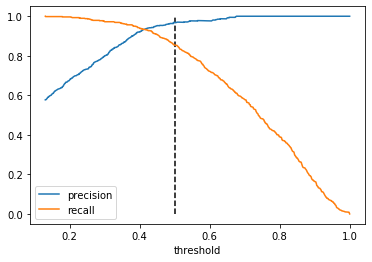

In [25]:
precision, recall, threshold = precision_recall_curve(train_labels, predicted_probs,
                                                      pos_label='partisan')
threshold = np.append(threshold, 1)

plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.vlines(0.5, 0, 1, linestyles='dashed')
plt.xlabel('threshold')
plt.legend()
plt.show()

Here we can see that for the training data, lowering the threshold a little would improve recall while only sacrificing a little precision.

Deciding on a decision threshold is usually something that we come to only once we are happy with the other parameters of our model and have finished training it. The threshold we choose for the final form of the model depends on the pros and cons of the two different kinds of mistakes in the particular field in which we want to apply the model. For example, if our model is intended for 'flagging' problematic articles that can then be reviewed by a human moderator, we might opt for a lower threshold, ensuring that we do not miss too many problematic articles. The false alarms can then be filtered out by the human moderator.

### Cross-validation

Now we want to estimate how well the model will generalize to new data that it has not learned from. It is tempting here to turn to our test data, but we should not do that yet. Remember that we want to keep the test data for a final check of the model's generalization performance after we are happy with it. We are not at this point yet. The reason that we want to check generalization performance at the moment is because we want to go back and change some of the model's parameters if its performance is not good enough.

Instead, we carry out another split of our training data, giving the model a subset to learn from, then checking how well it classifies the remaining items. We can even do this multiple times, splitting our training data into several so-called 'folds', then test the model on each fold after having trained it on the remaining ones. This process is called '*k*-fold cross-validation', where *k* is the number of folds. As with the initial training-test split, the choice of *k* involves a trade-off. Larger values mean that each fold is smaller, since we are dividing the data into more folds. This in turn means that the model gets a larger training data set for each fold, allowing it to get closer to its full learning potential, but a smaller test set, giving us a less precise estimate of generalization performance. A commonly-used and recommended value for *k* is 5.

When we carry out cross-validation, we need to organize some performance metrics that will be used to evaluate the model on each fold. Because the many possible metrics supplied in scikit-learn are very heterogeneous, they should be converted into a common format first, using a function `make_scorer` specifically for this purpose. A dictionary of such 'scorers' can be passed into the `cross_validate` function, along with the model and data, and the desired number of folds.

In [26]:
scorers = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, pos_label='partisan'),
           'recall': make_scorer(recall_score, pos_label='partisan')}

cv_result = cross_validate(model, train_items, train_labels,
                           cv=5,
                           scoring=scorers)

[Pipeline] ......... (step 1 of 4) Processing vectorize, total=   1.9s
[Pipeline] ......... (step 2 of 4) Processing transform, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing select, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing classify, total=   0.0s
[Pipeline] ......... (step 1 of 4) Processing vectorize, total=   1.8s
[Pipeline] ......... (step 2 of 4) Processing transform, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing select, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing classify, total=   0.0s
[Pipeline] ......... (step 1 of 4) Processing vectorize, total=   1.9s
[Pipeline] ......... (step 2 of 4) Processing transform, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing select, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing classify, total=   0.0s
[Pipeline] ......... (step 1 of 4) Processing vectorize, total=   1.9s
[Pipeline] ......... (step 2 of 4) Processing transform, total=   0.0s
[Pipel

The output is a dictionary of scores in which each value is a *k*-length array of the model's scores on the *k* folds. Also included is some information on how long it took to process each fold.

In [27]:
for key, value in cv_result.items():
    print('{}:\t{:.2f}\t{}'.format(key, np.mean(value), value))

fit_time:	1.92	[1.93899798 1.85552979 1.92671728 1.95279598 1.94692302]
score_time:	0.95	[0.94636035 1.07718849 0.93531489 0.89658761 0.91296816]
test_accuracy:	0.85	[0.85416667 0.84453782 0.85294118 0.87815126 0.81932773]
test_precision:	0.94	[0.93548387 0.96428571 0.94444444 0.95744681 0.875     ]
test_recall:	0.74	[0.75       0.70434783 0.73913043 0.7826087  0.73043478]


The model's accuracy in cross-validation is rather worse than the values we got above. This is to be expected. Above we were evaluating the model on the same data that it had learned from, whereas here we are evaluating the model on data that it did not 'see' during learning.

At this stage, we would usually return to some of the model parameters we defined above, such as the text preprocessing function, the cutoffs for exclusion of rare and frequent terms, and so on, and try to improve the model's cross-validation performance by altering them. We will omit doing this here, and imagine that we now have a finished model. We will also omit the final test of the model on the test data. This is left for you to try out if you have a go at tuning some of the parameters defined at the beginning of the notebook.

## Saving the model

If we are happy with the final form of the model, we will want to start using it. Before doing so, it is a good idea to re-fit the model to the entire data set. This ensures that the model maximizes what it learns from our data before we start applying it elsewhere.

In [28]:
model.fit(items, labels)

[Pipeline] ......... (step 1 of 4) Processing vectorize, total=   3.1s
[Pipeline] ......... (step 2 of 4) Processing transform, total=   0.1s
[Pipeline] ............ (step 3 of 4) Processing select, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing classify, total=   0.0s


Pipeline(memory=None,
         steps=[('vectorize',
                 CountVectorizer(analyzer=<function preprocess at 0x7f6fc234dc80>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=None, min_df=3,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('transform',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('select',
                 SelectPercentile(percentile=10,
                                  score_func=<function chi2

We can then save the model object using standard Python 'pickling', and load the model again for use in other applications.

In [29]:
with open('model.pickle', mode='wb') as f:
    pickle.dump(model, f)

del model

model = pickle.load(open('model.pickle', mode='rb'))

print(model.predict(['Computers are an abomination in the eyes of God! Turn away from sin!']))

['partisan']
